# Produce covariances from xs reconstruction rule

In [1]:
import sandy

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Cr-50 from JEFF-3.3 was identified as having covariance matrices (MF33) for the partial components of neutron inelastic scattering - i.e., MT=51-70 - but not for the MT=4.

## Plotting covariance matrices available in ENDF-6 file

In [4]:
mts = range(51, 56)  # only 5 reactions are selected

In [5]:
errorr = sandy.get_endf6_file("jeff_33", "xs", 240500).get_errorr(
    err=0.1,
    errorr33_kws=dict(
        mt=mts,
        irespr=0,  # faster
        ek=[1e6, 2e6, 5e6, 1e7, 2e7],  # only above threshold
    ),
    verbose=True,
)
cov = errorr['errorr33'].get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
2425 0 0 /
0.1 0. /
0/
moder
-22 30 /
errorr
-21 -22 0 33 0 /
2425 1 2 0 1 /
0 0.0 /
1 33 0/
5 0 /
51 52 53 54 55 /
4 /
1.00000e+06 2.00000e+06 5.00000e+06 1.00000e+07 2.00000e+07 /
stop

 njoy 2016.71  14Jul23                                       09/08/23 20:05:46
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.6s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 1.0s

 errorr...                                                                1.1s

 processing mat  2425
 ---------------------
  24-Cr- 50  KIT       EVAL-MAR10 P.Pereslavtsev, A. Konobeyev       

 covariances calculated for  5 reactions and   72 groups                  1.1s
         

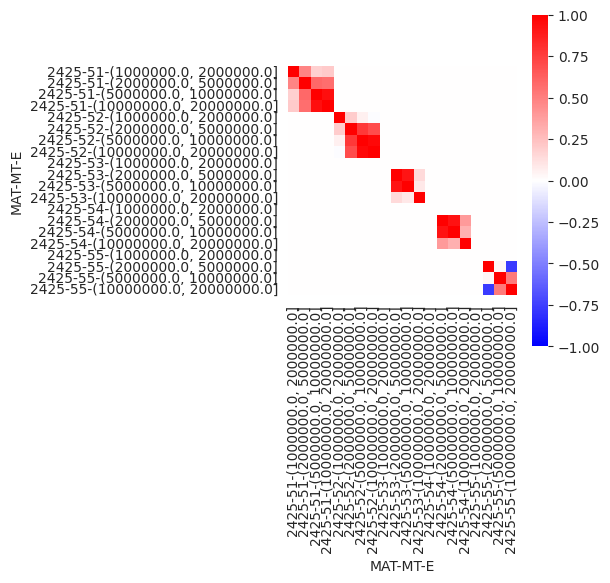

In [6]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_aspect("equal")
sns.heatmap(data=cov.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

## Transfering covariance info to random xs samples

In [7]:
tape = sandy.get_endf6_file("jeff_33", "xs", 240500).get_pendf(err=0.1)
xs = sandy.Xs.from_endf6(tape)

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    



 njoy 2016.71  14Jul23                                       09/08/23 20:05:52
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.6s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 1.0s
                                                                          1.1s
 *****************************************************************************


### Sampling cross sections **WITHOUT** reconstructing redundant cross section.

In [8]:
n = 50
smp = cov.sampling(n)
xs = sandy.Xs.from_endf6(tape)

xs_pert = []
for k, p in smp.iterate_xs_samples():
    x = sandy.core.xs.xs_perturb_worker(xs, n, p).data.unstack().rename("XS").reset_index().assign(SMP=k)
    xs_pert.append(x)
data = pd.concat(xs_pert, ignore_index=True)

filtered_data = data[data.MT.isin([4, 51, 52, 53])].query("E>7.9E5 & E<2e7")

/opt/hostedtoolcache/Python/3.11.5/x64/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


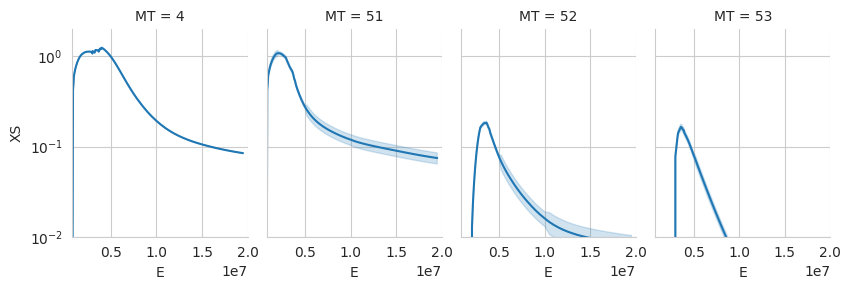

In [9]:
g = sns.relplot(
    data=filtered_data,
    x="E",
    y="XS",
    col="MT",
    kind="line",
    height=3, aspect=.7,
    errorbar="sd",
)
g.set(yscale="log", xlim=(7.9e5, 2e7), ylim=(1e-2, 2))
g.figure.set_dpi(100);

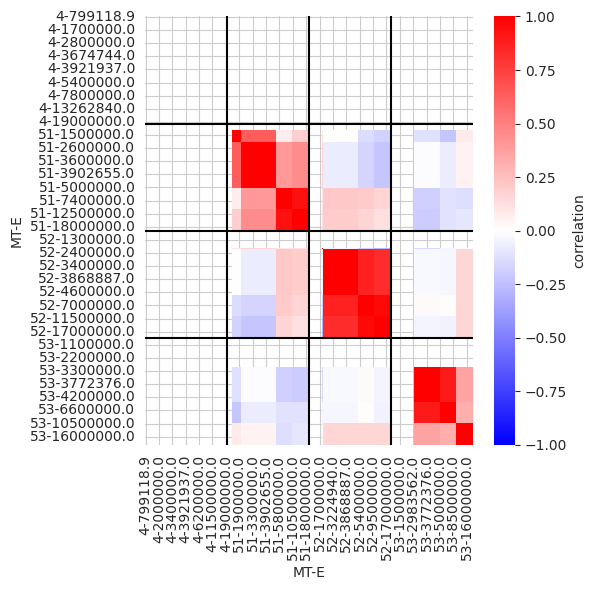

In [10]:
corr = filtered_data.pivot_table(index="SMP", columns=("MT", "E"), values="XS").corr()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, cbar_kws={'label': 'correlation'})
ax.axhline(98 * 1, color='k')
ax.axvline(98 * 1, color='k')
ax.axhline(98 * 2, color='k')
ax.axvline(98 * 2, color='k')
ax.axhline(98 * 3, color='k')
ax.axvline(98 * 3, color='k')

fig.tight_layout()

### Sampling cross sections **AND** reconstructing redundant cross section.

In [11]:
n = 50
smp = cov.sampling(n)
xs = sandy.Xs.from_endf6(tape)

xs_pert = []
for k, p in smp.iterate_xs_samples():
    x = sandy.core.xs.xs_perturb_worker(xs, n, p).reconstruct_sums(drop=True).data.unstack().rename("XS").reset_index().assign(SMP=k)
    xs_pert.append(x)
data = pd.concat(xs_pert, ignore_index=True)

filtered_data = data[data.MT.isin([4, 51, 52, 53])].query("E>7.9E5 & E<2e7")

/opt/hostedtoolcache/Python/3.11.5/x64/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


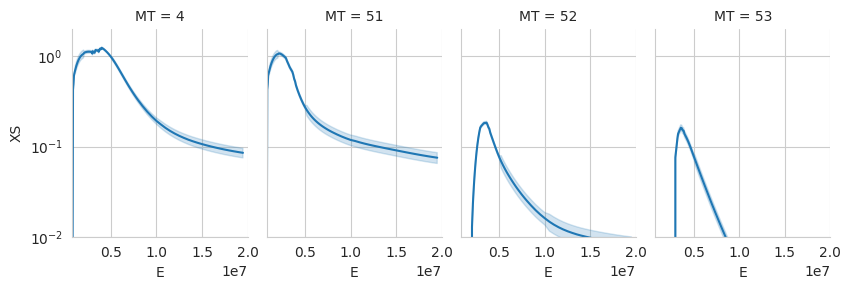

In [12]:
g = sns.relplot(
    data=filtered_data,
    x="E",
    y="XS",
    col="MT",
    kind="line",
    height=3, aspect=.7,
    errorbar="sd",
)
g.set(yscale="log", xlim=(7.9e5, 2e7), ylim=(1e-2, 2))
g.figure.set_dpi(100);

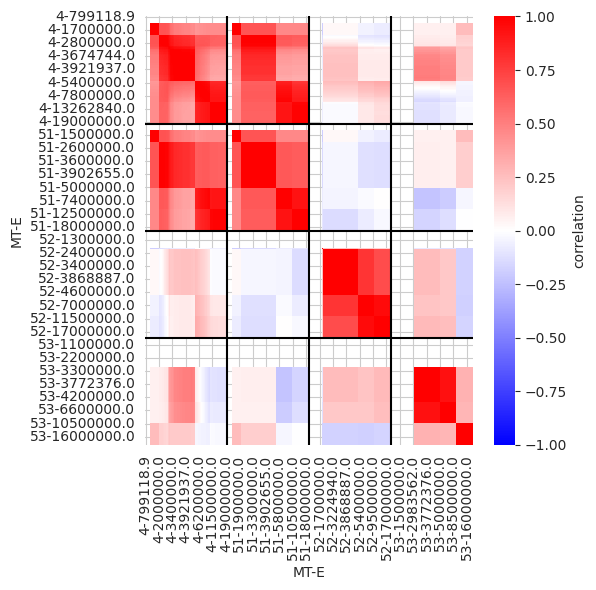

In [13]:
corr = filtered_data.pivot_table(index="SMP", columns=("MT", "E"), values="XS").corr()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, cbar_kws={'label': 'correlation'})
ax.axhline(98 * 1, color='k')
ax.axvline(98 * 1, color='k')
ax.axhline(98 * 2, color='k')
ax.axvline(98 * 2, color='k')
ax.axhline(98 * 3, color='k')
ax.axvline(98 * 3, color='k')

fig.tight_layout()